In [3]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, DiscreteHMCGibbs, Predictive

from jax import random
import jax
import jax.numpy as jnp
import torch

import arviz as az
import matplotlib.pyplot as plt

In [191]:
import skbio 
import numpy as np

## Preprocessing 

In [269]:
def seq_mapping(seq, alphabet):
    # Coding scheme
    # 0:A, 1:C, 2:G, 3:T 4:- (NOT YET:, 5:N)
    mapped = []
    for base in seq:
            mapped.append(alphabet.find(base))
    return jnp.array(mapped)

def fasta2ref(fref_in, alphabet):
    # Coding scheme
    # 0:A, 1:C, 2:G, 3:T 4:- (NOT YET:, 5:N)
    for seq in skbio.io.read(fref_in, format='fasta'):
        ref = seq_mapping(str(seq), alphabet)
    print('reference ', str(seq))
    return ref

def fasta2reads(freads_in, alphabet):
    # Coding scheme
    # 0:A, 1:C, 2:G, 3:T 4:- (NOT YET:, 5:N)
    reads_mapped = []
    print('reads')
    for seq in skbio.io.read(freads_in, format='fasta'):
        print(str(seq))
        reads_mapped.append(seq_mapping(str(seq), alphabet))
    return jnp.array(reads_mapped)

## Helpers

In [145]:
"""
Defining put_along_axis() from numpy for jax.numpy. 
Essentially copied the code from 
https://github.com/numpy/numpy/blob/4adc87dff15a247e417d50f10cc4def8e1c17a03/numpy/lib/shape_base.py#L29

"""

import numpy.core.numeric as _nx

def _make_along_axis_idx(arr_shape, indices, axis):
    # compute dimensions to iterate over
    if not _nx.issubdtype(indices.dtype, _nx.integer):
        raise IndexError('`indices` must be an integer array')
    if len(arr_shape) != indices.ndim:
        raise ValueError(
            "`indices` and `arr` must have the same number of dimensions")
    shape_ones = (1,) * indices.ndim
    dest_dims = list(range(axis)) + [None] + list(range(axis+1, indices.ndim))

    # build a fancy index, consisting of orthogonal aranges, with the
    # requested index inserted at the right location
    fancy_index = []
    for dim, n in zip(dest_dims, arr_shape):
        if dim is None:
            fancy_index.append(indices)
        else:
            ind_shape = shape_ones[:dim] + (-1,) + shape_ones[dim+1:]
            fancy_index.append(_nx.arange(n).reshape(ind_shape))

    return tuple(fancy_index)

def custom_put_along_axis(arr, indices, values, axis):
    """
    Parameters
    ----------
    arr : ndarray (Ni..., M, Nk...)
        Destination array.
    indices : ndarray (Ni..., J, Nk...)
        Indices to change along each 1d slice of `arr`. This must match the
        dimension of arr, but dimensions in Ni and Nj may be 1 to broadcast
        against `arr`.
    values : array_like (Ni..., J, Nk...)
        values to insert at those indices. Its shape and dimension are
        broadcast to match that of `indices`.
    axis : int
        The axis to take 1d slices along. If axis is None, the destination
        array is treated as if a flattened 1d view had been created of it.
    
    """
    
    # normalize inputs
    if axis is None:
        arr = arr.flat
        axis = 0
        arr_shape = (len(arr),)  # flatiter has no .shape
    else:
        #axis = normalize_axis_index(axis, arr.ndim)
        arr_shape = arr.shape

    # use the fancy index
    arr = arr.at[tuple(_make_along_axis_idx(arr_shape, indices, axis))].set(values)
    return arr

## Input

In [24]:
fref_in='../../test_data/super_small_ex/ref.fasta'
freads_in='../../test_data/super_small_ex/seqs.fasta'

In [26]:
alphabet ='ACGT-'
B = len(alphabet) # size alphabet

# Coding scheme
# 0:A, 1:C, 2:G, 3:T 4:-, 5:N

ref = fasta2ref(fref_in, alphabet)
reads = fasta2reads(freads_in, alphabet) # what about non-unique reads ? 

## Model - Finite DPM

#### Finite Dirichlet mixture model with fixed number of clusters. 

ref = reference sequence  
$N$ = number of reads  
$K$ = number of clusters/components  
$L$ = genome length (number of positions)
alphabet = {A, C, G, T, -}


no-mutation rate: $\gamma \sim Beta(a,b)$   
no-error rate: $\theta \sim Beta(c,d)$   
Cluster weights ($K$-dim): $\pi | \alpha \sim Dir(\alpha)$  
Cluster assignments ($N$-dim): $z|\pi \sim Categorical(\pi)$  
Cluster centers/haplotypes ($K$x$L$-dim): $h | ref, \gamma \sim Categorical(W) $ 
with $W(l,i)=
\begin{cases} 
\gamma,  \text{ if }i = ref[l] \\
\frac{1-\gamma}{4}, \text{ else. }
\end{cases}$ for $l \in {1, ..., L}$ and $i\in {1,..., |alphabet|}$  
Likelihood of the reads ($N$-dim): $r | z, h, \theta \sim Categorical(E)$ 
with $E(n,l,i)=
\begin{cases} 
\theta,  \text{ if }i = h_{z_n}[l] \\
\frac{1-\theta}{4}, \text{ else. }
\end{cases}$ for $n \in {1, ..., N}$, $l \in {1, ..., L}$ and $i\in {1,..., |alphabet|}$  



In [316]:
# --- 1. Example ----

reference = jnp.array([0])
reads = jnp.array([[0], [1], [1], [1], [0], [1], [0], [1]])

input_data = reference, reads

# --- 2. Example ----
fref_in='../../test_data/super_small_ex/ref.fasta'
freads_in='../../test_data/super_small_ex/seqs.fasta'

alphabet ='ACGT-'
alphabet_length = len(alphabet) # size alphabet

# Coding scheme
# 0:A, 1:C, 2:G, 3:T 4:-, 5:N

reference = fasta2ref(fref_in, alphabet)
print('reference ')
print(reference)
reads = fasta2reads(freads_in, alphabet)
print('reads ')
print(reads)

input_data = reference, reads, alphabet_length

cluster_num = 10

reference  GTTGAGT
reference 
[2 3 3 2 0 2 3]
reads
GTAAAGT
GTTGAGT
GTTGAGT
GTTGAGT
GTTTAGT
GTTTAGT
GTTTAGT
reads 
[[2 3 0 0 0 2 3]
 [2 3 3 2 0 2 3]
 [2 3 3 2 0 2 3]
 [2 3 3 2 0 2 3]
 [2 3 3 3 0 2 3]
 [2 3 3 3 0 2 3]
 [2 3 3 3 0 2 3]]


In [318]:
def model_finiteDPM(input_data):
    reference, read_data, alphabet_length = input_data

    # parameters
    read_count = read_data.shape[0]
    genome_length = read_data.shape[1]
    alphabet_length = alphabet_length

    # define rates
    mutation_rate = numpyro.sample('mutation_rate', dist.Beta(1, 1))
    error_rate = numpyro.sample('error_rate', dist.Beta(1, 1))

    # create matrix of rates
    mutation_rate_matrix = jnp.full((genome_length, alphabet_length), (1 - mutation_rate) / (alphabet_length - 1))
    mutation_rate_matrix = custom_put_along_axis(mutation_rate_matrix, reference.reshape(genome_length, 1), mutation_rate, axis=1)

    alpha = jnp.ones(cluster_num) / cluster_num
    cluster_weights = numpyro.sample("cluster_weights", dist.Dirichlet(alpha))

    genome_axis = numpyro.plate("genome_axis", genome_length, dim=-1)
    with numpyro.plate("haplotype_axis", cluster_num, dim=-2):
        
        with genome_axis:
           haplotypes = numpyro.sample("haplotypes", dist.Categorical(mutation_rate_matrix))  # cluster centers

    with numpyro.plate("read_axis", read_count, dim=-2):
        cluster_assignments = numpyro.sample("cluster_assignments", dist.Categorical(cluster_weights))
        
        with genome_axis:
            
            error_rate_matrix = jnp.full((read_count, genome_length, alphabet_length), (1 - error_rate) / (alphabet_length - 1))
            error_rate_matrix = custom_put_along_axis(error_rate_matrix, haplotypes[cluster_assignments].reshape(read_count, genome_length, 1), error_rate, axis=2)

            obs=numpyro.sample("obs", dist.Categorical(error_rate_matrix), obs=read_data)

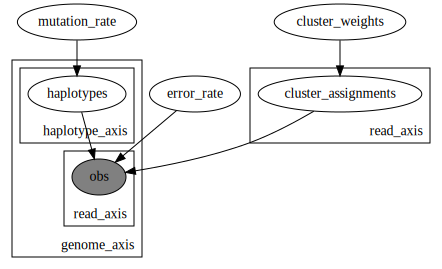

In [319]:
numpyro.render_model(model_finiteDPM, model_args=(input_data,))

In [321]:
rng_key = jax.random.PRNGKey(0)

num_warmup, num_samples = 2000, 10000

# Run NUTS. How many chains? 
kernel = NUTS(model_finiteDPM)
mcmc = MCMC(
    DiscreteHMCGibbs(kernel),
    num_warmup=num_warmup,
    num_samples=num_samples,
    num_chains=2
)
mcmc.run(rng_key, input_data)

/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_1277/2574899401.py:7: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:19<00:00, 601.71it/s, 31 steps of size 8.12e-02. acc. prob=0.90]


In [322]:
mcmc.print_summary()
# r_hat is the Gelman Rubin 


                              mean       std    median      5.0%     95.0%     n_eff     r_hat
cluster_assignments[0,0]      4.56      2.97      5.00      1.00      9.00   1004.50      1.00
cluster_assignments[1,0]      4.43      2.82      4.00      0.00      8.00   1024.95      1.00
cluster_assignments[2,0]      4.44      2.82      4.00      0.00      8.00    981.82      1.00
cluster_assignments[3,0]      4.45      2.83      4.00      0.00      8.00    937.76      1.00
cluster_assignments[4,0]      4.52      3.04      4.00      1.00      9.00    124.13      1.01
cluster_assignments[5,0]      4.52      3.04      4.00      1.00      9.00    125.58      1.01
cluster_assignments[6,0]      4.51      3.04      4.00      1.00      9.00    124.70      1.01
      cluster_weights[0]      0.10      0.18      0.00      0.00      0.38    233.30      1.01
      cluster_weights[1]      0.12      0.19      0.00      0.00      0.43    180.35      1.01
      cluster_weights[2]      0.09      0.17     

In [323]:
posterior_samples = mcmc.get_samples()

In [328]:
# Make sure to infer_discrete
# Predictive obtained by running model conditioned on latent samples from posterior_samples p(theta | data)

posterior_predictive = Predictive(model_finiteDPM, posterior_samples, infer_discrete=True)
posterior_predictions = posterior_predictive(rng_key, input_data=input_data)

In [329]:
inference_data = az.from_numpyro(
    posterior=mcmc,
    posterior_predictive=posterior_predictions,
)
display(inference_data)

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> observed_data

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

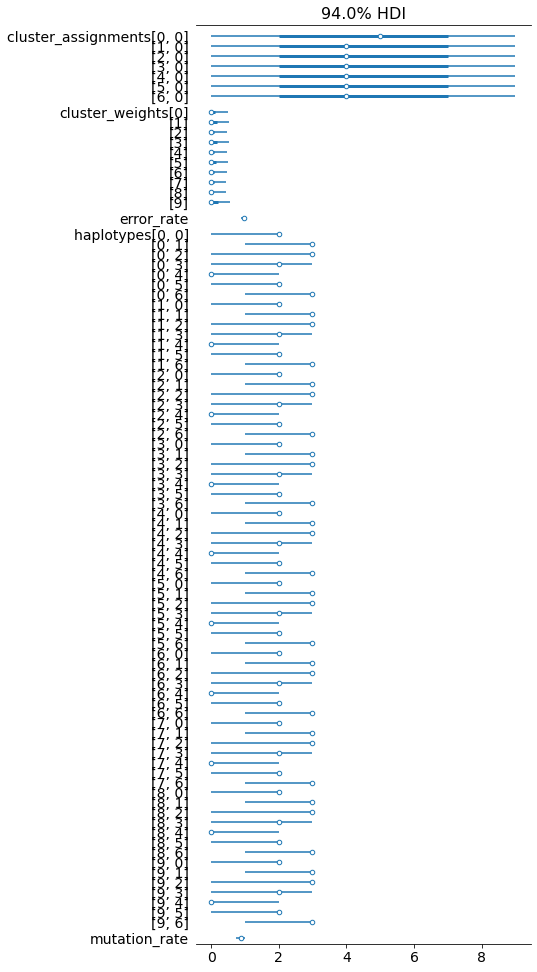

In [330]:
az.plot_forest(inference_data, combined=True)

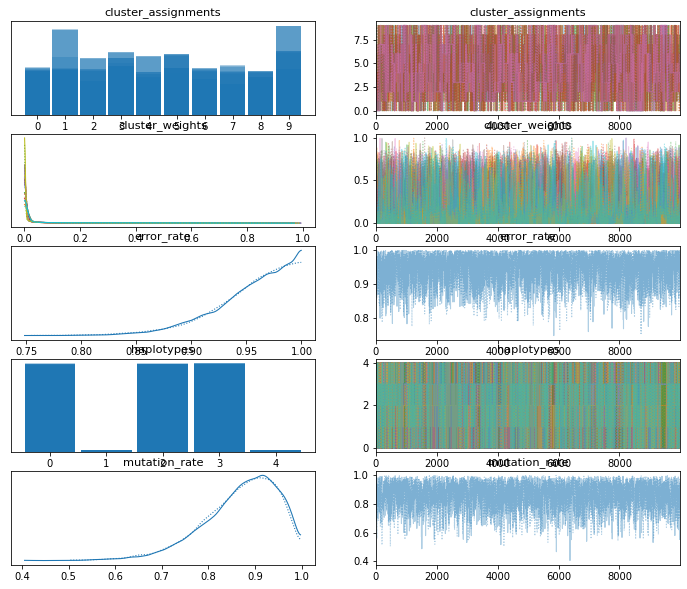

In [331]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True)
plt.show()

## Postprocessing

In [333]:
import scipy

In [313]:
def convert_h_to_seq(h, alphabet):
    '''
    Print the reconstructed haplotypes
    '''
    for k in range(h.shape[0]):
        seq=[]
        for base in h[k]:
            seq.append(alphabet[int(base)])
        print(k,':',''.join(seq))

In [332]:
# input reads
print(input_data[1])

[[2 3 0 0 0 2 3]
 [2 3 3 2 0 2 3]
 [2 3 3 2 0 2 3]
 [2 3 3 2 0 2 3]
 [2 3 3 3 0 2 3]
 [2 3 3 3 0 2 3]
 [2 3 3 3 0 2 3]]


In [334]:
# inferred haplotypes
scipy.stats.mode(posterior_samples['haplotypes'], axis=0)[0][0]

array([[2, 3, 3, 2, 0, 2, 3],
       [2, 3, 3, 2, 0, 2, 3],
       [2, 3, 3, 2, 0, 2, 3],
       [2, 3, 3, 2, 0, 2, 3],
       [2, 3, 3, 2, 0, 2, 3],
       [2, 3, 3, 2, 0, 2, 3],
       [2, 3, 3, 2, 0, 2, 3],
       [2, 3, 3, 2, 0, 2, 3],
       [2, 3, 3, 2, 0, 2, 3],
       [2, 3, 3, 2, 0, 2, 3]], dtype=int32)

In [335]:
# inferred cluster assignments
scipy.stats.mode(posterior_samples['cluster_assignments'], axis=0)[0][0]

array([[9],
       [3],
       [3],
       [3],
       [9],
       [9],
       [9]], dtype=int32)

In [338]:
# inferred no-mutation rate
np.mean(posterior_samples['mutation_rate'])

DeviceArray(0.8677984, dtype=float32)

In [339]:
# inferred no-error rate
np.mean(posterior_samples['error_rate'])

DeviceArray(0.9542655, dtype=float32)